# Advanced ML - HW4

## Flow control parameters

In [1]:
# ENVIRONMENT = 'Local'
ENVIRONMENT = 'Colab'

In [2]:
''' Each parameter can have the values:
  Process - run the process logic and save to disk
  Load - Load saved data from disk
  Disable - Do nothing
'''
SCALER_MODE = 'Train'
LABEL_ENCODER_MODE = 'Train'
TRAIN_MODEL_1 = 'Train'
TRAIN_MODEL_2 = 'Train'



## General parts - imports, mounts, load data, utility functions etc.

### Imports

In [3]:
%pip install langdetect
# %pip install pandas
# %pip install numpy
# %pip install tqdm
# %pip install matplotlib
# %pip install scikit-learn
# %pip install pytorch
%pip install transformers

In [4]:
from pathlib import Path

import json
import pandas as pd
import numpy as np
import string
import datetime
import re

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from os import cpu_count
import pickle

from langdetect import detect
from langdetect import DetectorFactory

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from transformers import DistilBertTokenizerFast
from transformers import AutoConfig, AutoModel
from transformers import DistilBertForSequenceClassification
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import spacy
from nltk import SnowballStemmer


if ENVIRONMENT == 'Colab':
    from google.colab import drive

### Mount drive, set paths

In [5]:
if ENVIRONMENT == 'Colab':
  drive.mount('/content/drive')
  data_path_train = Path('/content/drive/MyDrive/colab_data/aml_hw4/train_data_for_students.tsv')
  path_output = Path('/content/drive/MyDrive/colab_data/aml_hw4/outputs')

elif ENVIRONMENT == 'Local':
  data_path_train = Path('./train_data_for_students.tsv')
  path_output = Path('./outputs')

if not data_path_train.exists():
    raise FileNotFoundError('train data file not found!')

if not path_output.is_dir():
    path_output.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download data, to initial dataframe

In [6]:
data_train = pd.read_csv(data_path_train, sep='\t', lineterminator='\n', names=('id', 'alias', 'text', 'date_time', 'label'))
print(data_train.head(5))

                   id            alias  \
0  845974102619906048  realDonaldTrump   
1  846166053663191040  realDonaldTrump   
2  835814988686233601  realDonaldTrump   
3  835817351178301440  realDonaldTrump   
4  835916511944523777  realDonaldTrump   

                                                text            date_time  \
0  Democrats are smiling in D.C. that the Freedom...  2017-03-26 15:21:58   
1  General Kelly is doing a great job at the bord...  2017-03-27 04:04:42   
2  The race for DNC Chairman was, of course, tota...  2017-02-26 13:33:16   
3  For first time the failing @nytimes will take ...  2017-02-26 13:42:39   
4  Russia talk is FAKE NEWS put out by the Dems, ...  2017-02-26 20:16:41   

     label  
0   iphone  
1   iphone  
2  android  
3  android  
4  android  


## Data Cleanup

### Drop NA values

In [7]:
print(f'shape before:{data_train.shape}')
data_train.dropna(axis=0, inplace=True)
print(f'shape after:{data_train.shape}')


shape before:(2682, 5)
shape after:(2671, 5)


### Drop irrelevant label rows

In [8]:
data_train = data_train.loc[data_train['label'].isin(['iphone', 'android'])]

### Check data label balance

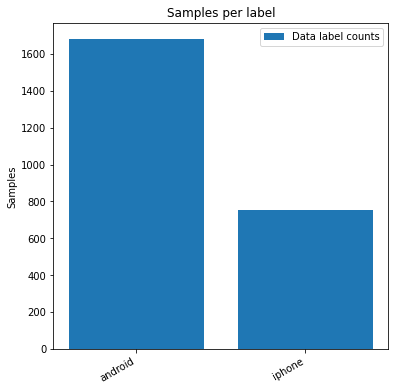

In [9]:
def labels_balance(data: pd.DataFrame, label_name: str):
  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  samples_per_label = pd.DataFrame(data[label_name].value_counts())
  samples_per_label.columns=['count']
  samples_per_label['percent'] = samples_per_label['count'].values / sum(samples_per_label['count'])

  
  fig, ax = plt.subplots(figsize=(6, 6))
  x = np.arange(len(samples_per_label))
  bars = ax.bar(x, samples_per_label['count'], label='Data label counts')
  
  ax.set_ylabel('Samples')
  ax.set_title(f'Samples per label')
  ax.set_xticks(x)
  ax.set_xticklabels(samples_per_label.index)

  if ENVIRONMENT == 'local':
    ax.bar_label(bars)

  ax.legend()
  plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
  
  plt.show()

  return(samples_per_label)

samples_per_label = labels_balance(data_train, 'label')


## Utility Functions

### compare attribute distribution android / iphone



In [10]:
def plot_bars_per_label(data: pd.DataFrame, attribute_name: str):
  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  x = np.arange(len(data.index))
  width = 0.35

  bars_iphone = ax[0].bar(x - width, data['iphone'], width, label='iphone tweets, log scale')
  bars_android = ax[0].bar(x, data['android'] ,width, label='Android tweets, log scale')

  ax[0].set_ylabel('tweets')
  ax[0].set_title(f'tweets per {attribute_name} per origin')

  bar_labels = list(data.index.values)
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(bar_labels)

  ax[0].set_yscale('log')
  ax[0].legend()

# percentage
  data_percentage = pd.DataFrame()
  data_percentage['iphone'] = data['iphone'] / (data['iphone'] + data['android'])
  data_percentage['android'] = data['android'] / (data['iphone'] + data['android'])

  bars_iphone = ax[1].bar(x, data_percentage['iphone'], label='iphone tweets, percent')
  bars_android = ax[1].bar(x, data_percentage['android'], bottom=data_percentage['iphone'], label='Android tweets, percent')

  ax[1].set_ylabel('tweets percent')
  ax[1].set_title(f'tweets percentage per {attribute_name} per origin')

  ax[1].set_xticks(x)
  ax[1].set_xticklabels(bar_labels)
  ax[1].legend()


  plt.show()

### Plot train progress - loss and accuracy

In [11]:
def plot_train_progress(data: pd.DataFrame):

  '''
  Gets: 
  data - pandas dataframe with attribute values in index, iphone and android columns with counts
  attribute name - string
  '''

  fig, ax = plt.subplots(figsize=(6, 6))
  ax_accuracy = ax.twinx()


  train_loss_line = ax.plot(data['epoch'], data['train_loss'], label='Train loss', color='b')
  validation_loss_line = ax.plot(data['epoch'], data['validation_loss'], label='Validation loss', color='r')
  validation_accuracy_line = ax_accuracy.plot(data['epoch'], data['validation_accuracy'], label='Validation accuracy', color='y')

  ax.set_ylabel('loss')
  ax_accuracy.set_ylabel('Accuracy')
  ax.set_title(f'Train progress per epoch')

  ax.legend()
  ax_accuracy.legend()

  plt.show()

## Feature Engineering
* Style based attributes:
  1. Has "Dumb retweets" - Boolean
  2. number of capital letters in tweet
  3. Contains URLs - Boolean
  5. Language - category string
  6. Hashtag count in text - int

* Time based attributes:
  1. Hour of day
  2. Minutes of day
  3. day of week
  4. day of month
  5. Month
  6. Year



In [12]:
SEED = 1234

# random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Function definitions for attribute engineering

#### Add language attribute

In [13]:
# Language detection
def get_string_language(string):
    """Gets the languages of each paper using fancy machine-learning"""
    try:
        return detect(''.join(string[:min(len(string), 50)]))
    except:       
        # Defaulting to English if failed to detect
        return 'en'
  

def get_text_language(texts):
  DetectorFactory.seed = 123
  langs = pd.Series(texts).progress_apply(get_string_language)
  return langs

#### Add "quote retweets" attribute

In [14]:
# quote retweet detection
def is_quote_retweet(string):
    """returns boolean - contains quote retweet True / False"""
    search_exp = '^@.*".*"'
    return not (re.search(search_exp, string) is None)


def get_text_quote_retweets(texts):
  quote_retweets = pd.Series(texts).progress_apply(is_quote_retweet)
  return quote_retweets

#### Add capital letter count attribute

In [15]:
# count of capital letters
def string_percent_caps(string):
    """returns float - % capital letters"""
    p_caps = sum(1 for c in string if c.isupper()) / len(string)
    return np.round(p_caps, 2)


def get_percent_caps(texts):
  percent_caps = pd.Series(texts).progress_apply(string_percent_caps)
  return percent_caps

#### Add contains url attribute

In [16]:
# url detection
def string_contains_url(string):
    """returns boolean - contains url True / False"""
    search_exp = 'http'
    return not (re.search(search_exp, string) is None)

def get_contains_url(texts):
  contains_url = pd.Series(texts).progress_apply(string_contains_url)
  return contains_url

#### Contains Hashtag attribute

In [17]:
# count of capital letters
def string_hashtag_count(string):
    """returns int - num capital letters"""
    h_count = sum(1 for c in string if c == '#')
    return h_count


def get_hashtag_count(texts):
  hashtag_count = pd.Series(texts).progress_apply(string_hashtag_count)
  return hashtag_count

#### Time based attributes

In [18]:
# date time attributes
def add_row_datetime_atts(row, date_time_col_name):
    """returns int - num capital letters"""
    if row[date_time_col_name] is not np.nan:
        datetime_obj = datetime.datetime.strptime(row[date_time_col_name], "%Y-%m-%d  %H:%M:%S")
        row['year'] = datetime_obj.year
        row['month'] = datetime_obj.month
        row['day'] = datetime_obj.day
        row['hour'] = datetime_obj.hour
        row['minute'] = datetime_obj.minute    
        row['weekday'] = datetime_obj.weekday()
        return row


def add_df_datetime_atts(dataframe, date_time_col_name):
    dataframe = dataframe.progress_apply(add_row_datetime_atts, args=[date_time_col_name], axis=1)
    return dataframe

#### Apply attribute enrichment to dataset

In [19]:
# Add all custom attributes

def add_custom_atts_to_df(dataframe):

  # Language is unreliable - not added. all treated as English 
  # print("Adding language attribute")
  # dataframe['lang'] = get_text_language(dataframe['text'])

  print("Adding quote_retweet attribute")
  dataframe['quote_retweet'] = get_text_quote_retweets(dataframe['text'])

  print("Adding percent_caps attribute")
  dataframe['percent_caps'] = get_percent_caps(dataframe['text'])

  print("Adding contains_url attribute")
  dataframe['contains_url'] = get_contains_url(dataframe['text'])

  print("Adding hashtag_count attribute")
  dataframe['hashtag_count'] = get_hashtag_count(dataframe['text'])

  print("Adding date/time attributes")
  dataframe = add_df_datetime_atts(dataframe, 'date_time')

  return dataframe

### Add attributes to train dataframe

In [20]:
print('Before:')
data_train.head(5)

Before:


,id,alias,text,date_time,label
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android


In [21]:
# Apply enrichment
data_train = add_custom_atts_to_df(data_train)



Adding quote_retweet attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding percent_caps attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding contains_url attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding hashtag_count attribute


  0%|          | 0/2438 [00:00<?, ?it/s]

Adding date/time attributes


  0%|          | 0/2438 [00:00<?, ?it/s]

#### Fix dtypes for all attributes:

In [22]:
# Fix dtypes

print(f'dtypes before: {data_train.dtypes}')
data_train = data_train.astype({'text': 'string', 
                   'date_time': 'object', 
                   'label': 'category', 
                  #  'lang': 'category', 
                   'quote_retweet': 'bool',
                   'percent_caps': 'float32',
                   'contains_url': 'bool',
                   'hashtag_count': 'int16',
                   'year': 'int16',
                   'month': 'int16',
                   'day': 'int16',
                   'hour': 'int16',
                   'minute': 'int16',
                   'weekday': 'category'})
print()
print(f'dtypes after: {data_train.dtypes}')



dtypes before: id                 int64
alias             object
text              object
date_time         object
label             object
quote_retweet       bool
percent_caps     float64
contains_url        bool
hashtag_count      int64
year               int64
month              int64
day                int64
hour               int64
minute             int64
weekday            int64
dtype: object

dtypes after: id                  int64
alias              object
text               string
date_time          object
label            category
quote_retweet        bool
percent_caps      float32
contains_url         bool
hashtag_count       int16
year                int16
month               int16
day                 int16
hour                int16
minute              int16
weekday          category
dtype: object


### Visualize engineered attributes


distribution of attribute quote_retweet:


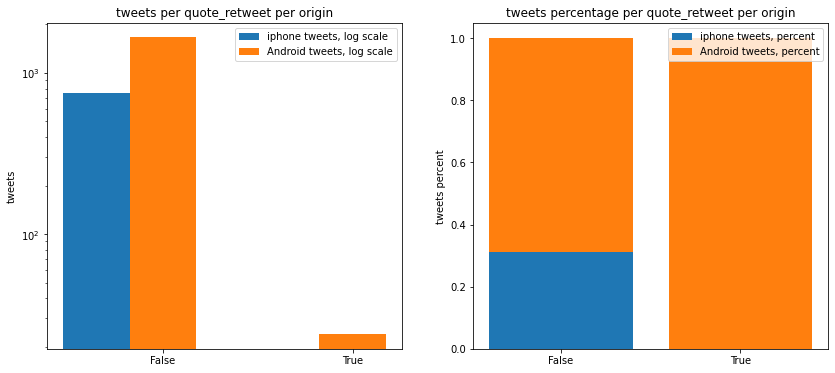


distribution of attribute percent_caps:


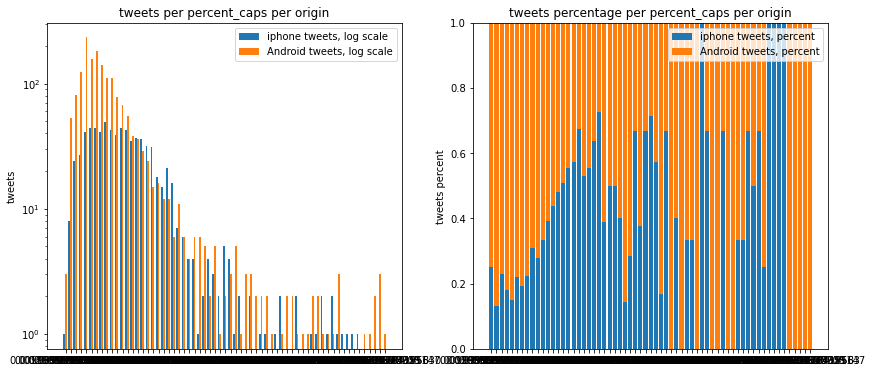


distribution of attribute contains_url:


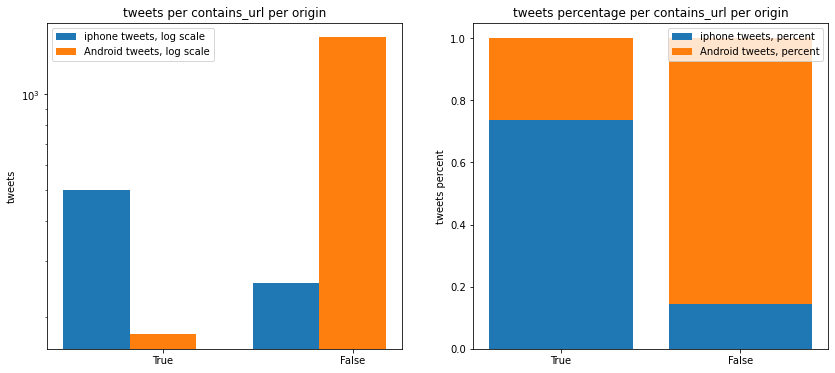


distribution of attribute hashtag_count:


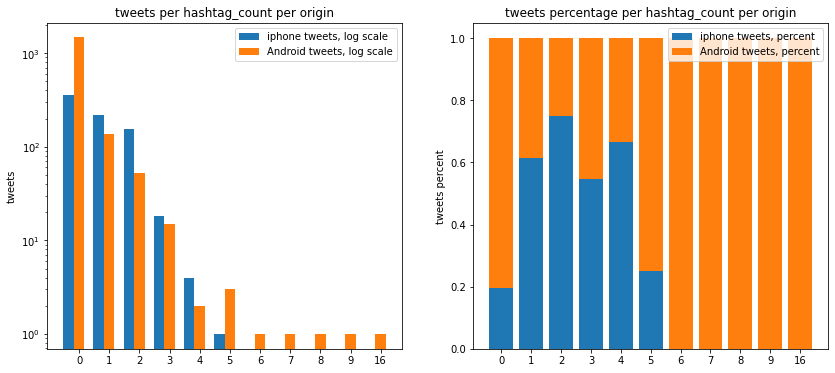


distribution of attribute year:


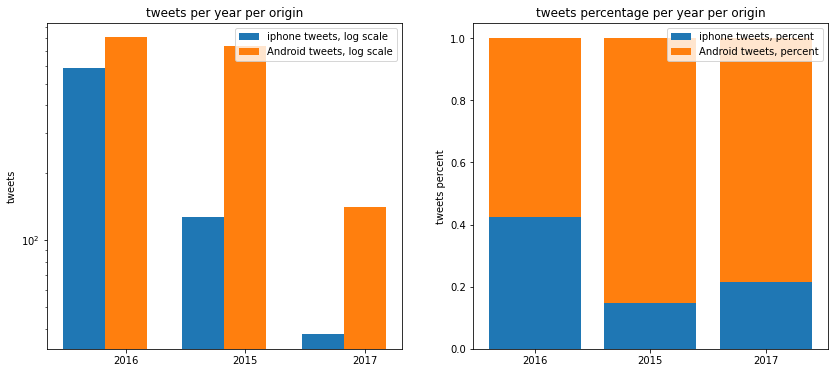


distribution of attribute month:


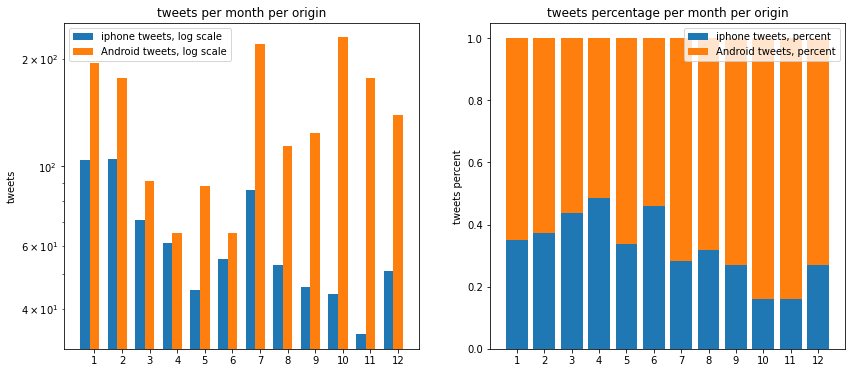


distribution of attribute day:


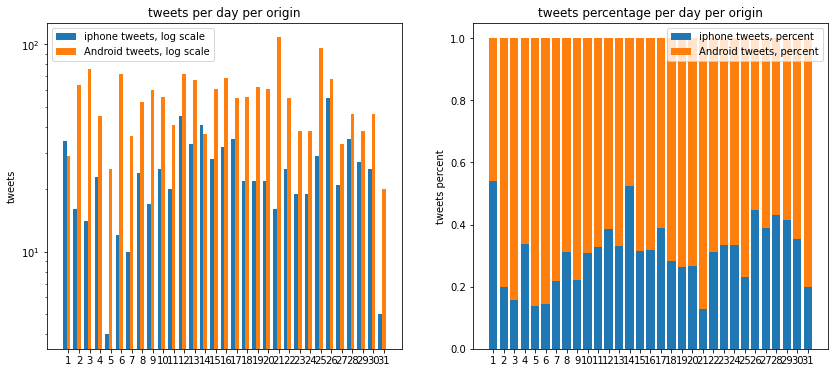


distribution of attribute hour:


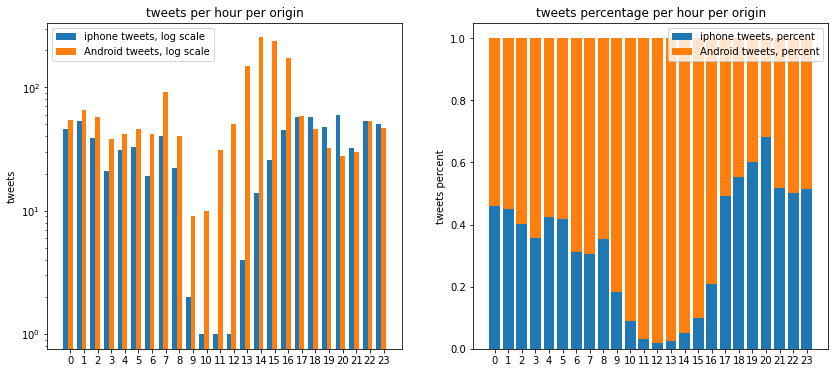


distribution of attribute minute:


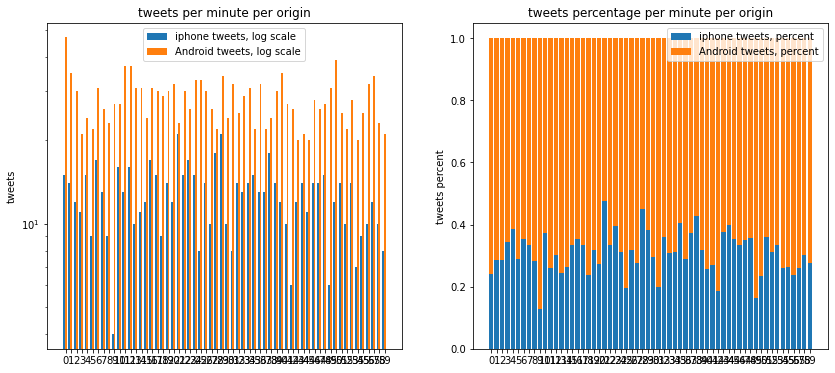


distribution of attribute weekday:


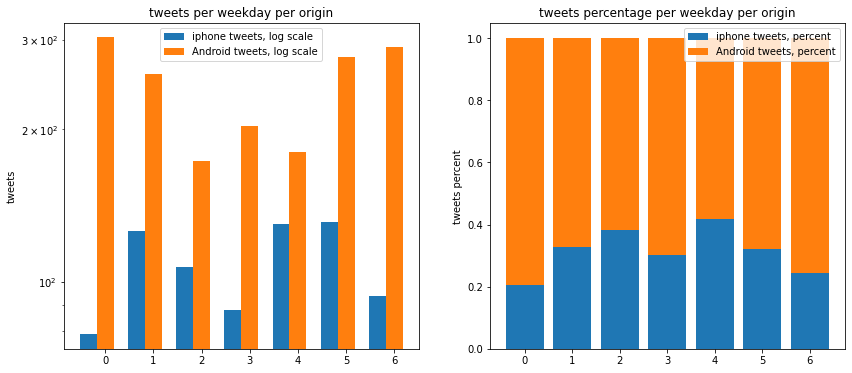

In [23]:
manual_classification_features = list(data_train.columns)
del manual_classification_features[0:5]

for attribute in manual_classification_features:
  print(f'distribution of attribute {attribute}:')

  tweets_per_att_iphone = data_train[data_train.label=='iphone'][attribute].value_counts()
  tweets_per_att_android = data_train[data_train.label=='android'][attribute].value_counts()
  tweets_per_att = pd.concat({'iphone': tweets_per_att_iphone, 'android': tweets_per_att_android}, axis = 1)
  tweets_per_att = tweets_per_att.fillna(0)
  plot_bars_per_label(tweets_per_att, attribute)
  print()


### Create label encoder

In [24]:
labels = data_train.label

data_path = path_output / Path('label_encoder.pickle')

if LABEL_ENCODER_MODE == 'Train':
  label_encoder = preprocessing.LabelEncoder().fit(labels)

  with open(data_path, 'wb') as handle:
    pickle.dump(label_encoder, handle)

elif LABEL_ENCODER_MODE == 'Load':
  with open(data_path, 'rb') as handle:
    label_encoder = pickle.load(handle)




### Create feature normalizer

In [25]:
from sklearn.preprocessing import MinMaxScaler

data_path = path_output / Path('min_max_scaler.pickle')

manual_classification_features = list(data_train.columns)
del manual_classification_features[0:6]
data_for_classification = data_train[manual_classification_features]

if SCALER_MODE == 'Train':
  scaler = MinMaxScaler().fit(data_for_classification)

  with open(data_path, 'wb') as handle:
    pickle.dump(label_encoder, handle)

elif SCALER_MODE == 'Load':
  with open(data_path, 'rb') as handle:
    label_encoder = pickle.load(handle)

### Create manual features dataset and label encoder for Pytorch

In [26]:
# Dataset and Dataloader for text features data

class ManualFeaturesDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, manual_features_data, labels=None, label_encoder=None):
        if labels is not None:
          assert len(manual_features_data) == len(labels)
        else:
          self.labels = None
        
        self.manual_features_data = manual_features_data
        
        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = pd.Series(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.manual_features_data)

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """

        if self.labels is not None:
          return torch.tensor(self.manual_features_data.iloc[idx, :]), torch.tensor(self.labels.iloc[idx])
        else:
          return torch.tensor(self.manual_features_data.iloc[idx, :])


In [27]:
# Manual features dataset object creation
# features to include
manual_features_ds = ManualFeaturesDataset(scaler.transform(data_for_classification), labels=labels, label_encoder=label_encoder)


# print(f'data_for_classification shape: {data_for_classification.shape}')
# print(f'data_for_classification sample: {data_for_classification.iloc[0, :]}')

# print(f'len(manual_features_ds): {len(manual_features_ds)}')
# print(f'manual_features_ds sample: {manual_features_ds[0]}')

## Prepare data for language models

### Preprocess text for language model

In [28]:
# find and replace hashtags with the word Hashtag

In [29]:
def preprocess_text_for_bart(string_list):
    preprocessed_text_list = pd.Series(string_list).copy()
    
    # TODO: preprocess here!
    
    return preprocessed_text_list

In [30]:
# preprocess - clean tweets, replace [urls, hashtags, names], update labels to numbers

# Create new clean text column
data_train.loc[:, 'text_for_lang_model'] = preprocess_text_for_bart(data_train.loc[:, 'text'])
# TODO: need to add cleanup logic here!

data_train.head()

,id,alias,text,date_time,label,quote_retweet,percent_caps,contains_url,hashtag_count,year,month,day,hour,minute,weekday,text_for_lang_model
0,845974102619906048,realDonaldTrump,Democrats are smiling in D.C. that the Freedom...,2017-03-26 15:21:58,iphone,False,0.08,False,0,2017,3,26,15,21,6,Democrats are smiling in D.C. that the Freedom...
1,846166053663191040,realDonaldTrump,General Kelly is doing a great job at the bord...,2017-03-27 04:04:42,iphone,False,0.03,False,0,2017,3,27,4,4,0,General Kelly is doing a great job at the bord...
2,835814988686233601,realDonaldTrump,"The race for DNC Chairman was, of course, tota...",2017-02-26 13:33:16,android,False,0.07,False,0,2017,2,26,13,33,6,"The race for DNC Chairman was, of course, tota..."
3,835817351178301440,realDonaldTrump,For first time the failing @nytimes will take ...,2017-02-26 13:42:39,android,False,0.01,False,0,2017,2,26,13,42,6,For first time the failing @nytimes will take ...
4,835916511944523777,realDonaldTrump,"Russia talk is FAKE NEWS put out by the Dems, ...",2017-02-26 20:16:41,android,False,0.07,False,0,2017,2,26,20,16,6,"Russia talk is FAKE NEWS put out by the Dems, ..."


### Tokenization

In [31]:
# get only relevant data as lists

def get_texts_and_labels_for_lang_model(dframe, text_col_name, label_col_name):
  return dframe[text_col_name].tolist(), dframe[label_col_name].tolist()


train_texts, train_labels = get_texts_and_labels_for_lang_model(data_train, 'text_for_lang_model', 'label')


In [32]:
# Tokenize texts
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)


In [33]:
len(train_encodings['input_ids'])

2438

### Prepare train datasets and data loaders

In [34]:
# Define datasets with texts and labels

class TextClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, encodings, labels = None, label_encoder=None):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
        """
        
        if labels is not None:
          assert len(encodings['input_ids']) == len(labels)
        else:
          self.labels = None
        
        self.encodings = encodings
        
        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = torch.tensor(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {}
        for key in self.encodings.keys():
            item[key] = torch.tensor(self.encodings[key][idx])
                
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx])
        
        return item



## Classifier model 1 - Bert fine-tuned Transformers classifier

### Imports

In [35]:
# Init:
  # preprocess for transforms - clean tweets, replace [urls, hashtags, names], tokenize text, change to tensor
  # Define datasets and dataloaders (Train, test, validation) with X and labels, ENGLISH only
  # Define model - Bart + classification layer

#Train:
  # Define loss function for classification
  # define optimizer (Adam?)
  # define function train_one_batch?
  # Define function train_one_epoch
  # define function train(num_epochs) with runtime reporting every batch and epoch, save model if better etc.


In [36]:
# Create dataset object:
TRAIN_DATASET_PORTION = 0.8
BATCH_SIZE = 30

full_dataset = TextClassificationDataset(train_encodings, labels=train_labels, label_encoder=label_encoder)
train_dataset_size = round(TRAIN_DATASET_PORTION * len(full_dataset))
validation_dataset_size = len(full_dataset) - train_dataset_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_dataset_size, validation_dataset_size])

full_dl = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE)
train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
validation_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)


### Classification Model based on distilbert

In [37]:
# 1 linear layers
class BertForSequenceClassification(nn.Module):
    """
    Simplified version of the same class by HuggingFace.
    See transformers/modeling_distilbert.py in the transformers repository.
    """

    def __init__(self, pretrained_model_name: str, num_classes: int = None, dropout: float = 0.3):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)

        self.lang_model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.classifier = nn.Linear(config.hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, features, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.
        Args:
            features (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        assert attention_mask is not None, "attention mask is none"

        bert_output = self.lang_model(input_ids=features, attention_mask=attention_mask, head_mask=head_mask)
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        scores = self.classifier(pooled_output)  # (bs, num_classes)

        return scores

### Fine-tune Bert model for current dataset

In [38]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [39]:
#Train configuration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

model = BertForSequenceClassification(model_name, num_classes=2)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()



Device: cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [40]:
def train_epoch(model, data_loader, optimizer, loss_function):
  model.train(True)
  train_loss = 0.0
  
  for i, batch in tqdm(enumerate(data_loader)):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
        
  return train_loss


In [41]:
def scores_to_class(scores):
  '''
  Gets a matrix with score per class, returns the class (argmax)
  '''
  
  classes = scores.argmax(axis=1).tolist()
  return classes


def evaluate_results(model, test_dl):
  epoch_loss = 0.0
  truth = []
  predictions = []
  raw_scores = None

  model.train(False)

  # onetime=True

  with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      epoch_loss += loss.item()

      truth += labels.tolist()
      predictions += scores_to_class(outputs)

  truth = np.array(truth)
  predictions = np.array(predictions)
 
  total_samples = len(truth)
  count_wrong = np.abs(truth - predictions).sum()
  count_right = total_samples - count_wrong
  accuracy = count_right / total_samples

  return epoch_loss, accuracy


In [42]:
PERFORMANCE_CSV_PATH = path_output / 'classifier1_train.csv' 

if TRAIN_MODEL_1 == 'Train':
  NUMBER_OF_EPOCHS_TO_TRAIN = 20
  PERFORMANCE_CSV_PATH = path_output / 'classifier1_train.csv' 

  results_per_epoch = pd.DataFrame(columns=['epoch', 'train_loss', 'validation_loss', 'validation_accuracy'])
  best_validation_accuracy = 0

  # test initial model performance
  epoch = 0
  print(f'Epoch {epoch}')
  validation_loss, validation_accuracy = evaluate_results(model, validation_dl)
  train_loss = 0
  results_per_epoch = results_per_epoch.append({'epoch': epoch, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
  print(results_per_epoch)
  results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

  # Train loop
  for epoch in tqdm(range(NUMBER_OF_EPOCHS_TO_TRAIN)):
    print(f'Epoch {epoch + 1}')
    train_loss = train_epoch(model, train_dl, optim, loss_function)
    validation_loss, validation_accuracy = evaluate_results(model, validation_dl)
    results_per_epoch = results_per_epoch.append({'epoch': epoch + 1, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
    print(results_per_epoch)
    results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

    # if better model:
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      model_path = path_output / Path(f'model_classifier1_{int(round(validation_accuracy, 3) * 1000)}.pickle')
      torch.save(model.state_dict(), model_path)

else:
  MODEL_PATH = path_output / Path('model_classifier1_final.pickle')
  model_state_dict = torch.load(MODEL_PATH)
  model.load_state_dict(model_state_dict)
  results_per_epoch = pd.read_csv(PERFORMANCE_CSV_PATH)


  

Epoch 0


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


   epoch  train_loss  validation_loss  validation_accuracy
0    0.0         0.0        12.330274             0.319672


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
Epoch 2


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
Epoch 3


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
Epoch 4


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
Epoch 5


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
5    5.0    1.936464         9.471314             0.901639
Epoch 6


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
5    5.0    1.936464         9.471314             0.901639
6    6.0    1.063428         9.456897             0.907787
Epoch 7


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
5    5.0    1.936464         9.471314             0.901639
6    6.0    1.063428         9.456897             0.907787
7    7.0    1.884378         6.241019             0.907787
Epoch 8


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
5    5.0    1.936464         9.471314             0.901639
6    6.0    1.063428         9.456897             0.907787
7    7.0    1.884378         6.241019             0.907787
8    8.0    0.606758         7.385151             0.918033
Epoch 9


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        12.330274             0.319672
1    1.0   24.799441         4.583136             0.887295
2    2.0   12.194862         3.615743             0.909836
3    3.0    5.195765         6.582214             0.909836
4    4.0    2.855049         4.509588             0.922131
5    5.0    1.936464         9.471314             0.901639
6    6.0    1.063428         9.456897             0.907787
7    7.0    1.884378         6.241019             0.907787
8    8.0    0.606758         7.385151             0.918033
9    9.0    0.241650         7.759690             0.920082
Epoch 10


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
Epoch 11


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
Epoch 12


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
Epoch 13


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
Epoch 14


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
Epoch 15


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        12.330274             0.319672
1     1.0   24.799441         4.583136             0.887295
2     2.0   12.194862         3.615743             0.909836
3     3.0    5.195765         6.582214             0.909836
4     4.0    2.855049         4.509588             0.922131
5     5.0    1.936464         9.471314             0.901639
6     6.0    1.063428         9.456897             0.907787
7     7.0    1.884378         6.241019             0.907787
8     8.0    0.606758         7.385151             0.918033
9     9.0    0.241650         7.759690             0.920082
10   10.0    0.179744         6.975187             0.918033
11   11.0    0.124537         7.773878             0.922131
12   12.0    0.064239         8.105937             0.920082
13   13.0    0.053273         8.191160             0.920082
14   14.0    0.043846         8.254863             0.920082
15   15.0    0.034542         8.518488  

### Classifier train performance

In [43]:
results_per_epoch

,epoch,train_loss,validation_loss,validation_accuracy
0,0.0,0.000000,12.330274,0.319672
1,1.0,24.799441,4.583136,0.887295
2,2.0,12.194862,3.615743,0.909836
3,3.0,5.195765,6.582214,0.909836
4,4.0,2.855049,4.509588,0.922131
5,5.0,1.936464,9.471314,0.901639
6,6.0,1.063428,9.456897,0.907787
7,7.0,1.884378,6.241019,0.907787
8,8.0,0.606758,7.385151,0.918033
9,9.0,0.241650,7.759690,0.920082


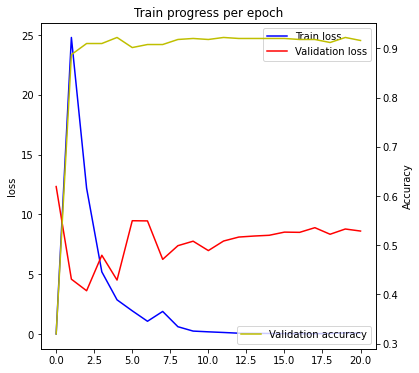

In [44]:
plot_train_progress(results_per_epoch)

## Classifier model 2 - MLP with Bert + manual engineered features


In [45]:
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.reset_accumulated_memory_stats()

### Prepare dataset

#### Unified dataset - Text and attributes

In [46]:
# Define datasets with texts and labels

class TextAndAttributesClassificationDataset(Dataset):
    """
    Wrapper around Torch Dataset to perform text classification
    """

    def __init__(self, text_dataset, atts_dataset, labels = None, label_encoder=None):
        """
        Args:
            texts (List[str]): a list with texts to classify or to train the
                classifier on
            labels List[str]: a list with classification labels (optional)
        """
        
        assert len(text_dataset) == len(atts_dataset)

        if labels is not None:
          assert len(atts_dataset) == len(labels)
        else:
          self.labels = None
        
        self.text_dataset = text_dataset
        self.atts_dataset = atts_dataset

        if labels is not None:
          if label_encoder is not None:
            self.label_encoder = label_encoder
          else:
            self.label_encoder = preprocessing.LabelEncoder().fit(labels)
          
          self.labels = torch.tensor(self.label_encoder.transform(labels))

    def __len__(self) -> int:
        """
        Returns:
            int: length of the dataset
        """
        return len(self.atts_dataset)

    def __getitem__(self, idx):
        """Gets element of the dataset

        Args:
            index (int): index of the element in the dataset
        Returns:
            Single element by index
        """
                
        if self.labels is not None:
          return {'text_encodings': self.text_dataset[idx], 'features': self.atts_dataset[idx], 'labels': self.labels[idx]}
        
        else:
          return {'text_encodings': self.text_dataset[idx], 'features': self.atts_dataset[idx]}



In [47]:
# create datasets and data loaders for train and validation
TRAIN_DATASET_PORTION = 0.8
BATCH_SIZE = 20

# standalone datasets - attributes and text
manual_features_nl_ds = ManualFeaturesDataset(data_for_classification)
text_nl_ds = TextClassificationDataset(train_encodings)

# full dataset
full_unified_ds = TextAndAttributesClassificationDataset(text_nl_ds, manual_features_nl_ds, labels=labels, label_encoder=label_encoder)

# Train / valid split
train_unified_ds_size = round(TRAIN_DATASET_PORTION * len(full_unified_ds))
validation_unified_ds_size = len(full_unified_ds) - train_unified_ds_size
train_unified_ds, validation_unified_ds = torch.utils.data.random_split(full_unified_ds, [train_unified_ds_size, validation_unified_ds_size])

# Data loaders
full_unified_dl = torch.utils.data.DataLoader(full_unified_ds, batch_size=BATCH_SIZE)
train_unified_dl = torch.utils.data.DataLoader(train_unified_ds, batch_size=BATCH_SIZE)
validation_unified_dl = torch.utils.data.DataLoader(validation_unified_ds, batch_size=BATCH_SIZE)

In [48]:
# print(f'full_unified_ds: {len(full_unified_ds)}')
# print(f'full_unified_ds sample: {full_unified_ds[0]}')

# print(f'train_unified_ds: {len(train_unified_ds)}')
# print(f'train_unified_ds sample: {train_unified_ds[0]}')

# for i in full_unified_dl:
#   print(i)
#   break

### Classification Model

In [49]:
# Dropouts added between layers
class BertAndFeaturesForSequenceClassification(nn.Module):
    """
    Combines bert, additional features and classifier layers
    """

    def __init__(self, num_manual_features:int, pretrained_model_name: str, lang_linear_layer_dim:int = 150, num_classes: int = None, dropout: float = 0.3):
        """
        Args:
            pretrained_model_name (str): HuggingFace model name.
                See transformers/modeling_auto.py
            num_classes (int): the number of class labels
                in the classification task
        """
        super().__init__()

        config = AutoConfig.from_pretrained(pretrained_model_name, num_labels=num_classes)      
        self.num_manual_features = num_manual_features
        self.lang_model = AutoModel.from_pretrained(pretrained_model_name, config=config)
        self.linear_after_lang = nn.Linear(config.hidden_size, lang_linear_layer_dim)
        self.linear_after_features = nn.Linear(num_manual_features, num_manual_features)
        self.linear_after_concat = nn.Linear(num_manual_features + lang_linear_layer_dim, num_manual_features + lang_linear_layer_dim)
        self.classifier = nn.Linear(num_manual_features + lang_linear_layer_dim, num_classes)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()


    def forward(self, features, encodings, attention_mask=None, head_mask=None):
        """Compute class probabilities for the input sequence.
        Args:
            encodings (torch.Tensor): ids of each token,
                size ([bs, seq_length]
            attention_mask (torch.Tensor): binary tensor, used to select
                tokens which are used to compute attention scores
                in the self-attention heads, size [bs, seq_length]
            head_mask (torch.Tensor): 1.0 in head_mask indicates that
                we keep the head, size: [num_heads]
                or [num_hidden_layers x num_heads]
        Returns:
            PyTorch Tensor with predicted class scores
        """
        
        assert attention_mask is not None, "attention mask is none"

        # Language + linear branch
        bert_output = self.lang_model(input_ids=encodings, attention_mask=attention_mask, head_mask=head_mask)
        seq_output = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = seq_output.mean(axis=1)  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)

        linear_after_lang_output = self.linear_after_lang(pooled_output) 
        linear_after_lang_output = self.dropout(linear_after_lang_output)

        # attributes branch
        linear_after_features_output = self.linear_after_features(features)
        linear_after_features_output = self.relu(linear_after_features_output)
        linear_after_features_output = self.dropout(linear_after_features_output)

        # Unified branch
        concat_vector = torch.cat([linear_after_lang_output, linear_after_features_output], axis=1)

        linear_after_concat_output = self.linear_after_concat(concat_vector)
        linear_after_concat_output = self.relu(linear_after_concat_output)
        linear_after_concat_output = self.dropout(linear_after_concat_output)

        
        #classifier layer
        scores = self.classifier(linear_after_concat_output)  # (bs, num_classes)

        return scores
  

### Train unified model

In [50]:
#Train configuration

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Device: {device}')

model = BertAndFeaturesForSequenceClassification(9, model_name, lang_linear_layer_dim=150, num_classes=2)
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)
loss_function = nn.CrossEntropyLoss()



Device: cuda


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
def train_epoch(model, data_loader, optimizer, loss_function):
  model.train(True)
  train_loss = 0.0
  
  for i, batch in tqdm(enumerate(data_loader)):
      features = batch['features'].to(device)
      input_ids = batch['text_encodings']['input_ids'].to(device)
      attention_mask = batch['text_encodings']['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      optimizer.zero_grad()
      outputs = model(features, input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
        
  return train_loss


In [52]:
def scores_to_class(scores):
  '''
  Gets a matrix with score per class, returns the class (argmax)
  '''
  
  classes = scores.argmax(axis=1).tolist()
  return classes


def evaluate_results(model, test_dl):
  epoch_loss = 0.0
  truth = []
  predictions = []
  raw_scores = None

  model.train(False)

  # onetime=True

  with torch.no_grad():
    for i, batch in tqdm(enumerate(test_dl)):
      features = batch['features'].to(device)
      input_ids = batch['text_encodings']['input_ids'].to(device)
      attention_mask = batch['text_encodings']['attention_mask'].to(device)
      labels = batch['labels'].to(device)

      outputs = model(features, input_ids, attention_mask=attention_mask)
      loss = loss_function(outputs, labels)
      epoch_loss += loss.item()

      truth += labels.tolist()
      predictions += scores_to_class(outputs)

      # if onetime:
      #   print(f'labels: {labels}')
      #   print(f'truth: {truth}')
      #   print(f'outputs: {truth}')
      #   print(f'predictions: {truth}')
      #   onetime = False


  truth = np.array(truth)
  predictions = np.array(predictions)
 
  total_samples = len(truth)
  count_wrong = np.abs(truth - predictions).sum()
  count_right = total_samples - count_wrong
  accuracy = count_right / total_samples

  return epoch_loss, accuracy


In [53]:
PERFORMANCE_CSV_PATH = path_output / 'classifier2_train.csv' 

if TRAIN_MODEL_2 == 'Train':
  NUMBER_OF_EPOCHS_TO_TRAIN = 20

  results_per_epoch = pd.DataFrame(columns=['epoch', 'train_loss', 'validation_loss', 'validation_accuracy'])
  best_validation_accuracy = 0

  # test initial model performance
  epoch = 0
  print(f'Epoch {epoch}')
  validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
  train_loss = 0
  results_per_epoch = results_per_epoch.append({'epoch': epoch, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
  print(results_per_epoch)
  results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

  # Train loop
  for epoch in tqdm(range(NUMBER_OF_EPOCHS_TO_TRAIN)):
    print(f'Epoch {epoch+1}')
    train_loss = train_epoch(model, train_unified_dl, optim, loss_function)
    validation_loss, validation_accuracy = evaluate_results(model, validation_unified_dl)
    results_per_epoch = results_per_epoch.append({'epoch': epoch+1, 'train_loss': train_loss, 'validation_loss': validation_loss, 'validation_accuracy': validation_accuracy}, ignore_index=True)
    print(results_per_epoch)
    results_per_epoch.to_csv(PERFORMANCE_CSV_PATH)

    # if better model:
    if validation_accuracy > best_validation_accuracy:
      best_validation_accuracy = validation_accuracy
      model_path = path_output / Path(f'model_classifier2_{int(round(validation_accuracy, 3) * 1000)}.pickle')
      torch.save(model.state_dict(), model_path)

else:
  MODEL_PATH = path_output / Path('model_classifier2_final.pickle')
  model_state_dict = torch.load(MODEL_PATH)
  model.load_state_dict(model_state_dict)
  results_per_epoch = pd.read_csv(PERFORMANCE_CSV_PATH)

Epoch 0


0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0         0.0        67.227937             0.252049


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
Epoch 2


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
Epoch 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
Epoch 4


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
Epoch 5


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
5    5.0  103.133579        27.421719             0.903689
Epoch 6


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
5    5.0  103.133579        27.421719             0.903689
6    6.0   94.543140        51.976803             0.860656
Epoch 7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
5    5.0  103.133579        27.421719             0.903689
6    6.0   94.543140        51.976803             0.860656
7    7.0   58.922807        34.914218             0.930328
Epoch 8


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
5    5.0  103.133579        27.421719             0.903689
6    6.0   94.543140        51.976803             0.860656
7    7.0   58.922807        34.914218             0.930328
8    8.0   49.263156        32.713084             0.928279
Epoch 9


0it [00:00, ?it/s]

0it [00:00, ?it/s]

   epoch  train_loss  validation_loss  validation_accuracy
0    0.0    0.000000        67.227937             0.252049
1    1.0  446.486682        20.497638             0.913934
2    2.0  232.041855        24.044922             0.918033
3    3.0  191.466323        25.406681             0.922131
4    4.0  116.510715        12.031916             0.897541
5    5.0  103.133579        27.421719             0.903689
6    6.0   94.543140        51.976803             0.860656
7    7.0   58.922807        34.914218             0.930328
8    8.0   49.263156        32.713084             0.928279
9    9.0   36.807581        34.216107             0.928279
Epoch 10


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
Epoch 11


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
Epoch 12


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
Epoch 13


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
Epoch 14


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
Epoch 15


0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

0it [00:00, ?it/s]

0it [00:00, ?it/s]

    epoch  train_loss  validation_loss  validation_accuracy
0     0.0    0.000000        67.227937             0.252049
1     1.0  446.486682        20.497638             0.913934
2     2.0  232.041855        24.044922             0.918033
3     3.0  191.466323        25.406681             0.922131
4     4.0  116.510715        12.031916             0.897541
5     5.0  103.133579        27.421719             0.903689
6     6.0   94.543140        51.976803             0.860656
7     7.0   58.922807        34.914218             0.930328
8     8.0   49.263156        32.713084             0.928279
9     9.0   36.807581        34.216107             0.928279
10   10.0   22.821738        37.252767             0.934426
11   11.0   16.056665        36.865401             0.922131
12   12.0   12.274717        39.643603             0.938525
13   13.0   15.221671        38.784655             0.932377
14   14.0   10.756756        39.838796             0.938525
15   15.0   12.787513        34.133638  

### Classifier train performance

In [54]:
results_per_epoch

,epoch,train_loss,validation_loss,validation_accuracy
0,0.0,0.000000,67.227937,0.252049
1,1.0,446.486682,20.497638,0.913934
2,2.0,232.041855,24.044922,0.918033
3,3.0,191.466323,25.406681,0.922131
4,4.0,116.510715,12.031916,0.897541
5,5.0,103.133579,27.421719,0.903689
6,6.0,94.543140,51.976803,0.860656
7,7.0,58.922807,34.914218,0.930328
8,8.0,49.263156,32.713084,0.928279
9,9.0,36.807581,34.216107,0.928279


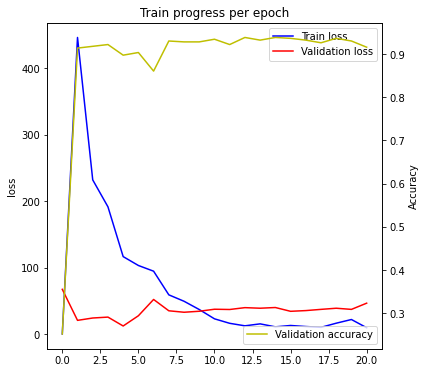

In [55]:
plot_train_progress(results_per_epoch)